In [44]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
from cleaning_datasets import loading_dissected_datasets

In [4]:
def build_model(verbose=False):
    regressor = keras.Sequential()
    regressor.add(keras.layers.LSTM(units = 128, return_sequences = True, input_shape=(lookback,1)))
    regressor.add(keras.layers.Dropout(0.2))

    regressor.add(keras.layers.LSTM(units = 64, return_sequences = True))
    regressor.add(keras.layers.Dropout(0.15))

    regressor.add(keras.layers.LSTM(units = 32, return_sequences = True))
    regressor.add(keras.layers.Dropout(0.15))

    regressor.add(keras.layers.LSTM(units = 64, return_sequences = False))
    regressor.add(keras.layers.Dropout(0.15))

    regressor.add(keras.layers.Dense(units=64,activation='relu'))
    regressor.add(keras.layers.Dense(units=32,activation='relu'))
    regressor.add(keras.layers.Dense(units=16,activation='relu'))
    regressor.add(keras.layers.Dense(units=8,activation='tanh'))
    regressor.add(keras.layers.Dense(units=1))

    regressor.compile(optimizer='adam',loss="mean_squared_error",metrics=["accuracy"])
    if verbose:
        regressor.summary()
    return regressor 


In [5]:
df = loading_dissected_datasets(12, 12)

In [6]:
test_period = 30 #days
train_data = df[:df.shape[0]-test_period]["mean"]
test_data = df[df.shape[0]-test_period:]["mean"]

In [7]:
scaler = MinMaxScaler()
train_data = np.array(train_data).reshape(-1,1)
test_data = np.array(test_data).reshape(-1,1)

train_data = scaler.fit_transform(train_data)
train_data = train_data.reshape(-1)

test_data = scaler.transform(test_data).reshape(-1)

In [8]:
EMA = 0.0
gamma = 0.3
for ti in range(train_data.shape[0]):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

In [9]:
jump=1
lookback = 80
X_train,y_train = [],[]
for i in range(lookback,train_data.size,jump):
    X_train.append(train_data[i-lookback:i])
    y_train.append(train_data[i])
X_train,y_train = np.array(X_train),np.array(y_train)
 
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

In [10]:
regressor = build_model()

In [11]:
history = regressor.fit(X_train,y_train,batch_size=32,epochs=50,use_multiprocessing=True)


Epoch 1/50
8/8 [==============================] - 6s 131ms/step - loss: 0.0963 - accuracy: 0.0000e+00
Epoch 2/50
8/8 [==============================] - 1s 128ms/step - loss: 0.0236 - accuracy: 0.0000e+00
Epoch 3/50
8/8 [==============================] - 1s 125ms/step - loss: 0.0217 - accuracy: 0.0000e+00
Epoch 4/50
8/8 [==============================] - 1s 125ms/step - loss: 0.0197 - accuracy: 0.0000e+00
Epoch 5/50
8/8 [==============================] - 1s 127ms/step - loss: 0.0158 - accuracy: 0.0000e+00
Epoch 6/50
8/8 [==============================] - 1s 128ms/step - loss: 0.0184 - accuracy: 0.0000e+00
Epoch 7/50
8/8 [==============================] - 1s 164ms/step - loss: 0.0208 - accuracy: 0.0000e+00
Epoch 8/50
8/8 [==============================] - 2s 203ms/step - loss: 0.0211 - accuracy: 0.0000e+00
Epoch 9/50
8/8 [==============================] - 1s 133ms/step - loss: 0.0176 - accuracy: 0.0000e+00
Epoch 10/50
8/8 [==============================] - 1s 132ms/step - loss: 0.0183 - 

In [24]:
real_stock_price = df.iloc[df.shape[0]-test_period:df.shape[0],0:1]
inputs =  df["mean"][(len(df)-len(real_stock_price)-lookback):].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(lookback, lookback+test_period):
    X_test.append(inputs[i-lookback:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (test_period, lookback ,1))

real_stock_price = np.array(real_stock_price)

#%%
'''Predicting and inverse-transform the prices for the 30 days'''
predicted = regressor.predict(X_test)
predicted = scaler.inverse_transform(predicted)

In [15]:
test_data = []
for i in range(1, 30):
    # print(len(df.iloc[-80-i:-i])
    test_data.append(df.iloc[-80-i:-i]["mean"].values.tolist())

In [25]:
predicted

array([[0.17660896],
       [0.18034473],
       [0.20002523],
       [0.2270325 ],
       [0.2518241 ],
       [0.25713044],
       [0.25135696],
       [0.26560333],
       [0.31546122],
       [0.36356384],
       [0.36786848],
       [0.32922974],
       [0.27231914],
       [0.21868233],
       [0.1847032 ],
       [0.20770046],
       [0.2976557 ],
       [0.38114962],
       [0.41165957],
       [0.39901298],
       [0.37324283],
       [0.3640617 ],
       [0.35597518],
       [0.3362564 ],
       [0.30974802],
       [0.27933443],
       [0.26194823],
       [0.28116962],
       [0.35047552],
       [0.45628121]], dtype=float32)

In [30]:
secdf = loading_dissected_datasets(13, 12)

In [22]:
print(len(test_data))

29


In [31]:
actual, pred = [], []

In [32]:
for i in range(30):
    print(secdf.iloc[i, -1], predicted[i][0])
    actual.append(secdf.iloc[i, -1])
    predicted[i][0]

0.2936187401574803 0.17660896
0.3718851574803149 0.18034473
0.3643251968503937 0.20002523
0.41673322834645676 0.2270325
0.3490499212598425 0.2518241
0.3864378346456693 0.25713044
0.3916232677165354 0.25135696
0.467046968503937 0.26560333
0.35559484251968504 0.31546122
0.4581697637795276 0.36356384
0.3886850787401575 0.36786848
0.2762301574803149 0.32922974
0.1479241338582677 0.27231914
0.35397874015748026 0.21868233
0.2996172834645669 0.1847032
0.44110614173228346 0.20770046
0.4985825590551181 0.2976557
0.5217446456692914 0.38114962
0.530793779527559 0.41165957
0.4578453937007874 0.39901298
0.2587888976377953 0.37324283
0.3433670472440945 0.3640617
0.37188129921259844 0.35597518
0.19712192913385823 0.3362564
0.12016704724409448 0.30974802
0.11159976377952754 0.27933443
0.24175291338582677 0.26194823
0.37312515748031494 0.28116962
0.44655263779527565 0.35047552
0.40366240157480315 0.45628121


In [44]:
len(actual)

30

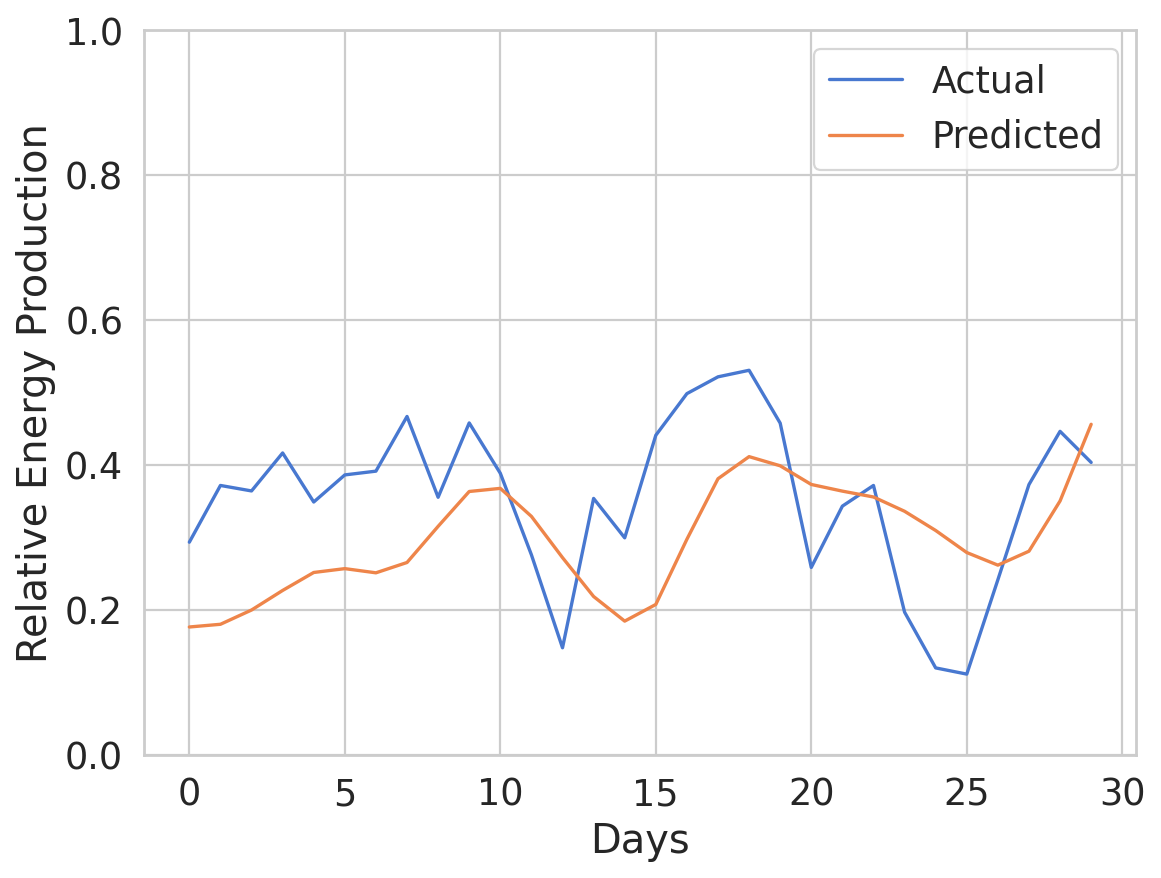

In [52]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.plot(actual, label="Actual")
plt.plot(predicted, label="Predicted")
plt.ylim(0, 1)
plt.xlabel("Days")
plt.ylabel("Relative Energy Production")
plt.legend()

In [37]:
import sklearn.metrics
import math

mse = sklearn.metrics.mean_squared_error(actual, predicted.reshape(-1).tolist())

rmse = math.sqrt(mse)

In [38]:
rmse

0.13050217310438905

In [45]:
del(plt)

In [53]:
import statistics
statistics.stdev(predicted.reshape(-1).tolist())

0.07506323560606662